In [ ]:
import os
import argparse
!pip install google-cloud-videointelligence
from google.cloud import videointelligence


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.4/229.4 KB 18.8 MB/s eta 0:00:00


In [ ]:
!pip install ffmpeg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for ffmpeg: filename=ffmpeg-1.4-py3-none-any.whl size=6084 sha256=5e8b60417880a5df07ffb9b7be6cc40e93cba0cbba41cc2674078218de57baeb
  Stored in directory: /root/.cache/pip/wheels/1d/57/24/4eff6a03a9ea0e647568e8a5a0546cdf957e3cf005372c0245
Successfully built ffmpeg


In [ ]:
import subprocess

In [ ]:
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/content/google_account_key.json'

In [ ]:
video_client = videointelligence.VideoIntelligenceServiceClient()

In [ ]:
from google.cloud import storage
global uri
client = storage.Client()
bucket = client.get_bucket("dummy_video_api")
blobs = list(bucket.list_blobs())

Adelaide Tourism 15 TVC.mp4
/tmp/Adelaide Tourism 15 TVC.mp4
	Shot 0: 0.0 to 1.88
Time of this shot 1.88
	Shot 1: 1.92 to 2.7199999999999998
Time of this shot 0.7999999999999998
	Shot 2: 2.76 to 3.44
Time of this shot 0.6800000000000002
	Shot 3: 3.48 to 3.96
Time of this shot 0.48
	Shot 4: 4.0 to 4.48
Time of this shot 0.4800000000000004
	Shot 5: 4.52 to 5.44
Time of this shot 0.9200000000000008
	Shot 6: 5.48 to 6.32
Time of this shot 0.8399999999999999
	Shot 7: 6.36 to 7.2
Time of this shot 0.8399999999999999
	Shot 8: 7.24 to 8.08
Time of this shot 0.8399999999999999
	Shot 9: 8.12 to 9.0
Time of this shot 0.8800000000000008
	Shot 10: 9.04 to 10.56
Time of this shot 1.5200000000000014
	Shot 11: 10.6 to 14.96
Time of this shot 4.360000000000001
Total time for all the shots 14.520000000000003
The number time the shots changed is: 11
The average time of each frame is: 1.3200000000000003
The standard deviation of the shot times is: 1.0300161811026727


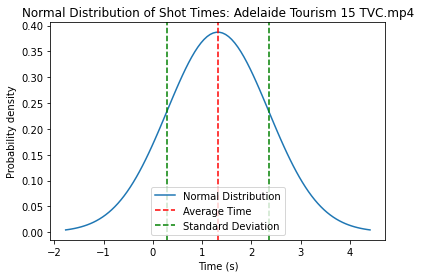

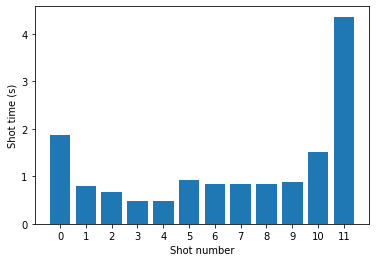

The average frame time for all videos is: 1.3200000000000003
The total average standard deviation for all videos is: 1.0300161811026727
Airwick Freshmatic 15s TVC.mp4
/tmp/Airwick Freshmatic 15s TVC.mp4
	Shot 0: 0.0 to 2.56
Time of this shot 2.56
	Shot 1: 2.6 to 3.7199999999999998
Time of this shot 1.1199999999999997
	Shot 2: 3.76 to 5.08
Time of this shot 1.3200000000000003
	Shot 3: 5.12 to 5.92
Time of this shot 0.7999999999999998
	Shot 4: 5.96 to 8.84
Time of this shot 2.88
	Shot 5: 8.88 to 11.04
Time of this shot 2.1599999999999984
	Shot 6: 11.08 to 12.36
Time of this shot 1.2799999999999994
	Shot 7: 12.4 to 14.96
Time of this shot 2.5600000000000005
Total time for all the shots 14.679999999999998
The number time the shots changed is: 7
The average time of each frame is: 2.097142857142857
The standard deviation of the shot times is: 0.7869522714568022


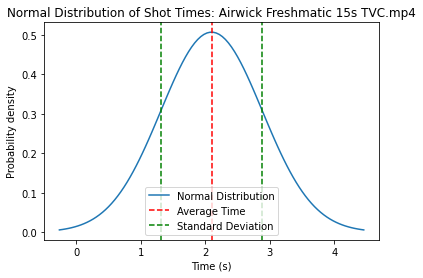

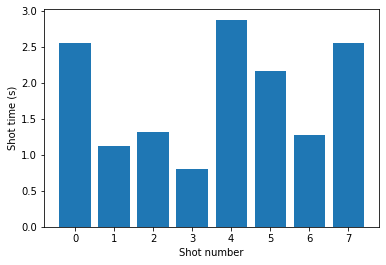

The average frame time for all videos is: 1.7085714285714286
The total average standard deviation for all videos is: 0.9084842262797375


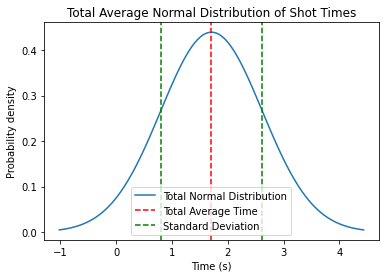

In [ ]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

standard_dev_for_each_video = []
no_cut_scenes_videos = []
average_frame_time_for_each_video = []
for blob in bucket.list_blobs():
    print(blob.name)
    input_path = f"/tmp/{blob.name}"
    cmd = f"ffmpeg -i {input_path}"
    subprocess.call(cmd, shell=True)
    print(input_path)
        
    # Upload the output file to the same bucket
    #output_blob = bucket.blob(output_name)
    #print(output_blob)

    operation = video_client.annotate_video(input_uri="gs://dummy_video_api/"+blob.name, features=['SHOT_CHANGE_DETECTION'],)
    result = operation.result()
    #print(result)
    annotation_res_shot = result.annotation_results[0]
    # Empty list
    shot_times = []
    for i, shot in enumerate(annotation_res_shot.shot_annotations): 
        start_time = (shot.start_time_offset.seconds + shot.start_time_offset.microseconds / 1e6)
        end_time = (shot.end_time_offset.seconds + shot.end_time_offset.microseconds / 1e6)
        print("\tShot {}: {} to {}".format(i, start_time, end_time))
        shot_time = end_time - start_time
        # Time taken for each shot
        print('Time of this shot', shot_time)
        # Appending to the list
        shot_times.append(shot_time)
        
    # Calculating Sum of total shot time
    total_time = sum(shot_times)
    print('Total time for all the shots', total_time)
    
    # Calculating the number of shots
    print('The number time the shots changed is:', i)

    # Calculating the average shot time
    average_time = total_time / i
    print('The average time of each frame is:', average_time)
    
    # Appending the average times of all the videos
    average_frame_time_for_each_video.append(average_time)

    # Calculating the standard deviation
    variance = sum([((x - average_time) ** 2) for x in shot_times]) / len(shot_times)
    standard_deviation = math.sqrt(variance)
    print('The standard deviation of the shot times is:', standard_deviation)
    
    # Append the standard deviation value to the list
    standard_dev_for_each_video.append(standard_deviation)
    
    if standard_deviation != 0.0:
        # Generate x values for normal distribution
        x = np.linspace(average_time - 3 * standard_deviation, average_time + 3 * standard_deviation, 100)

        # Calculate the corresponding y values for the normal distribution
        y = 1 / (standard_deviation * math.sqrt(2 * math.pi)) * np.exp(-(x - average_time) ** 2 / (2 * standard_deviation ** 2))
        
        # Create a plot of the normal distribution
        plt.plot(x, y, label='Normal Distribution')

        # Add a vertical line for the average time
        plt.axvline(x=average_time, color='red', linestyle='--', label='Average Time')

        # Add vertical lines for one standard deviation above and below the mean
        plt.axvline(x=average_time + standard_deviation, color='green', linestyle='--', label='Standard Deviation')
        plt.axvline(x=average_time - standard_deviation, color='green', linestyle='--')

        # Add labels and a title to the plot
        plt.xlabel('Time (s)')
        plt.ylabel('Probability density')
        plt.title('Normal Distribution of Shot Times: {}'.format(blob.name))

        # Add a legend to the plot
        plt.legend()

        # Show the plot
        plt.show()
        
    else:
        no_cut_scenes_videos.append(blob.name)
        print("\n\nVideos without cut scenes:")
        for shots in no_cut_scenes_videos:
            print(shots)
        print("\nTotal number of videos without shot: "+str(len(no_cut_scenes_videos)))
    
    # Rearranging the labels to start the x axis from zero
    x_labels = np.arange(len(shot_times))
    
    # Plotting the bar plot with respect to the length of shot times
    plt.bar(range(len(shot_times)), shot_times)

    # set x-tick labels
    plt.xticks(range(len(shot_times)), range(len(shot_times)))

    # set axis labels
    plt.xlabel('Shot number')
    plt.ylabel('Shot time (s)')

    # show plot
    plt.show()

    total_average_time = sum(average_frame_time_for_each_video) / len(average_frame_time_for_each_video)
    print('The average frame time for all videos is:', total_average_time)

    # Calculate the average standard deviation of all videos
    total_average_standard_deviation = sum(standard_dev_for_each_video) / len(standard_dev_for_each_video)
    print('The total average standard deviation for all videos is:', total_average_standard_deviation)

    # Generate x values for normal distribution
    x = np.linspace(total_average_time - 3 * total_average_standard_deviation, total_average_time + 3 * total_average_standard_deviation, 100)

# Calculate the corresponding y values for the normal distribution
y = 1 / (total_average_standard_deviation * math.sqrt(2 * math.pi)) * np.exp(-(x - total_average_time) ** 2 / (2 * total_average_standard_deviation ** 2))

# Create a plot of the normal distribution
plt.plot(x, y, label='Total Normal Distribution')

# Add a vertical line for the average time
plt.axvline(x=total_average_time, color='red', linestyle='--', label='Total Average Time')

# Add vertical lines for one standard deviation above and below the mean
plt.axvline(x=total_average_time + total_average_standard_deviation, color='green', linestyle='--', label='Standard Deviation')
plt.axvline(x=total_average_time - total_average_standard_deviation, color='green', linestyle='--')

# Add labels and a title to the plot
plt.xlabel('Time (s)')
plt.ylabel('Probability density')
plt.title('Total Average Normal Distribution of Shot Times')

# Add a legend to the plot
plt.legend()

# Show the plot
plt.show()
